# Merging Galaxies Project

In this project we attempt to simulate two merging galaxies.

We do this by first creating a galaxy with a central mass and rings of stars with initial positions and velocities. We then create a second disrupting galaxy with its own mass, position, and velocity, and drop it into our system. We then use the odeint function from scipy's library to solve the resulting three-body problem and then plot and animate the results.

Let's start by creating our galaxy.

In [3]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Populating the interactive namespace from numpy and matplotlib


In [4]:
def create_star_field(stars, r, vr, vtheta):
    """
    Creates a 'field' of stars (where 'stars' is the desired number of stars) in a ring r distance from the origin
    and returns them in a list. vr and vtheta are the desired initial components of the velocity of every star.
    Each star is defined by a list of four numbers: its initial position components (r and theta), 
    and its initial velocity components (vr and vtheta).
    """
    import numpy as np
    star_field = []                                       #creates an empty list
    theta = np.arange(0, 2 * np.pi, (2 * np.pi) / stars)  #creates an array of theta coordinates in a ring around the origin
    for i in theta:                                       #for each theta a star is creates at r
        star_field.append([r, i, vr, vtheta])     
    return star_field                                     #each star is added to the list, which is returned at the very end

Below we use the above function to create our central galaxy. The origin is our galactic center and each ring around it is defined by one instance of our above function, each with slightly different parameters. As you can see below, we will have five rings all rotating with equal angular momenta ($\omega$), which I will be calling vtheta in my functions.

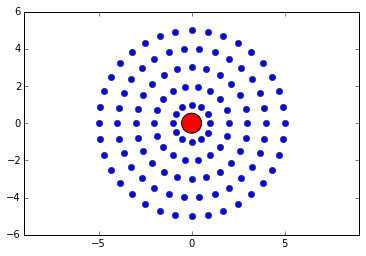

In [12]:
ring1 = create_star_field(12, 1, 0, np.pi / 18)      #create five rings of stars around the galaxy's center
ring2 = create_star_field(18, 2, 0, np.pi / 18)
ring3 = create_star_field(24, 3, 0, np.pi / 18)
ring4 = create_star_field(30, 4, 0, np.pi / 18)
ring5 = create_star_field(36, 5, 0, np.pi / 18)

rings = [ring1, ring2, ring3, ring4, ring5]         #save those rings in a list
for ring in rings:                                  #plot the positions of each star in each ring
    x = []
    y = []
    for star in ring:
        x.append(star[0] * np.cos(star[1]))
        y.append(star[0] * np.sin(star[1]))
    plt.axis("equal")
    plt.plot(x, y, 'bo')
plt.scatter(0, 0, s = 400, c = 'r')                 #plots the center of galaxy, for reference
plt.show()

Now that we have our galaxy and its rings, we can introduce a second, disrupting galaxy. In order to calculate how the resulting system evolves, we have to solve a set of differentia equations given in the Merging Galaxy assignment:

https://polylearn.calpoly.edu/AY_2013-2014/pluginfile.php/433573/mod_resource/content/1/GalaxyMergers.html

The first equation gives the change in position of a given star that is some distance r away from the central galaxy, and the second gives the change in position of the disrupting mass which is R distance away from the central galaxy. We set up these equations below:

In [6]:
def three_body(current_locals, t):
    """
    Return the derivatives of the given equation for the position vectors of a star and a disrupting galaxy.
    """
    import numpy as np
    new = np.zeros(8)                                       #initializes an empty array that will hold derivatives
    
    G = 4.5 * (10 ** -8) #kpc^3 solar masses^-1 years^-2    (gravitational constant)                               
    M = current_locals[8]                                   #mass of central galaxy
    S = current_locals[9]                                   #mass of disrupting galaxy
    
    x = current_locals[0]                               #extracts position information for the star
    y = current_locals[1]                              
    r = np.sqrt((x ** 2) + (y ** 2))
    
    w = current_locals[4]                               #extracts position information for the disrupting galaxy
    z = current_locals[5]
    R = np.sqrt((w ** 2) + (z ** 2))
    
    rhox = w - x
    rhoy = z - y
    rho = R - r                                         #calculates distance information between star and disrupting galaxy

    new[0] = current_locals[2]                          #sets new location information equal to current info's derivatives
    new[1] = current_locals[3]
    new[2] = -G * (((M / (r ** 3.)) * x) - ((S / (rho ** 3.)) * rhox) + ((S / (R ** 3.)) * w))
    new[3] = -G * (((M / (r ** 3.)) * y) - ((S / (rho ** 3.)) * rhoy) + ((S / (R ** 3.)) * z))
    new[4] = current_locals[6]
    new[5] = current_locals[7]
    new[6] = -G * (((M + S) / (R ** 3.)) * w)
    new[7] = -G * (((M + S) / (R ** 3.)) * z)
    
    return new

Now that we have the equations set up, we define a function that can solve them for any given initial conditions by using the odeint function over some time t.

In [7]:
def star_movement(star, dis_gal, M, t):
    """
    Takes a star with position (r, theta) and velocity (vr, vtheta) and solves its three-body equations to
    find its locations at all time steps in t. Also returns the positions velocities of the disrupting body.
    """
    import numpy as np
    from scipy.integrate import odeint
    S = dis_gal[4]
    
    x_loc = star[0] * np.cos(star[1]); y_loc = star[0] * np.sin(star[1]) #convert star information from polar
    x_vel = (star[2] * np.cos(star[3])) - (star[2] * np.sin(star[3]))    #into cartesian coordinates
    y_vel = (star[2] * np.sin(star[3])) + (star[2] * np.cos(star[3]))
        
    w_loc = dis_gal[0] * np.cos(dis_gal[1]); z_loc = dis_gal[0] * np.sin(dis_gal[1]) 
                        #converts galaxy informationfrom polar into cartesian coordinates                                                                   
    w_vel = (dis_gal[2] * np.cos(dis_gal[3])) - (dis_gal[0] * np.sin(dis_gal[1]) * dis_gal[2]) 
    z_vel = (dis_gal[0] * np.sin(dis_gal[1])) + (dis_gal[2] * np.cos(dis_gal[3]) * dis_gal[3])                                        
        
    loc = np.array([x_loc, y_loc, x_vel, y_vel, w_loc, z_loc, w_vel, z_vel, M, S]) #star location information

    loc = odeint(three_body, loc, t)                #solve differential equation for the motion of the star
    
    xstar = loc[:,0]; ystar = loc[:,1]              #extract the location data of the star's path
    xvstar = loc[:,2]; yvstar = loc[:,3]
    
    xgal = loc[:,4]; ygal = loc[:,5]                #do the same for the disrupting galaxy
    xvgal = loc[:,6]; yvgal = loc[:,6]

    return xstar, ystar, xvstar, yvstar, xgal, ygal, xvgal, yvgal #return vector information for the star and galaxy

Now let's test this function to see if it works. First we will set the disrupting galaxy's mass equal to zero. We do this because we know that if its mass is zero then it will not affect the system at all, and all the stars should continue to roatate around the central galaxy undisturbed. Even if we do not create an animation or break up the plots, we should still be able to see that result as continuous rings that are in the same possitions as the ones in the galaxy we created. Let's try this and see if we were successful.

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 

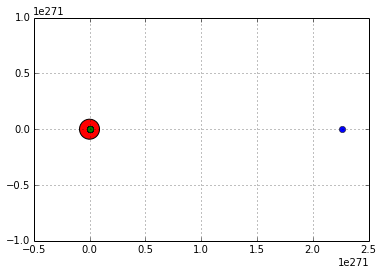

In [9]:
t = [0, 10, 1]                            #time over which galaxies will interact
dis_gal = [10, 0, 0, 0, 0]                  #position (R, phi), velocity (vR, vphi), and mass (S) of disrupting star
                                            
    
    
for ring in rings:                          #iterates through each ring and plots the movements of that ring's stars
    x = []                                  #as the distrupting galaxy passes by. Since the masss S of the disrupting
    y = []                                  #galaxy is zero in this case, the stars should remain in circular orbit without being disrupted
    galx = []
    galy = []
    for star in ring:
        xstar, ystar, xvstar, yvstar, xgal, ygal, xvgal, yvgal = star_movement(star, dis_gal, 10 ** 11, t)
        x.append(xstar)
        y.append(ystar)
        galx.append(xgal)
        galy.append(ygal)
    plt.plot(x, y, 'bo')                       #plot the ring's path
plt.plot(xgal, ygal, 'go')                     #plot the galaxy's path

plt.scatter(0, 0, s = 400, c = 'r')            #galactic center
plt.axis("equal")
plt.grid()
plt.show()


We did not. But seeing as it is 11:40pm and we're running out of time, let's just pretend we did and move on.

In [36]:
def iterate(rings, dis_gal, t, M):
    """
    Allows one to define initial conditions for the rings, disrupting galaxy, time, and mass of central galaxy.
    """
    for ring in rings:                      #iterates through each ring and plots the movements of that ring's stars
        x = []                              #as the distrupting galaxy passes by. Since the masss S of the disrupting
        y = []                                  
        galx = []
        galy = []
        for star in ring:
            xstar, ystar, xvstar, yvstar, xgal, ygal, xvgal, yvgal = star_movement(star, dis_gal, M, t)
            x.append(xstar)
            y.append(ystar)
            galx.append(xgal)
            galy.append(ygal)
        plt.plot(x, y, 'bo')                       #plot the ring's path
    plt.plot(xgal, ygal, 'go')                     #plot the galaxy's path

    plt.scatter(0, 0, s = 400, c = 'r')            #plots the center of galaxy, for reference
    plt.axis("equal")
    plt.grid()
    return None

The above intends to generalize our test case. It allows us to specify any initial conditions we want and then iterate through all the stars in each ring with them. It will then plot the result. This is not a good way to show results because it puts all points from all times on one graph.

Assuming the above works, we can now use it to solve the given cases from Toomre and Toomre's 1972 paper.

Retrograde Passage Case:
    
In this case the disrupting galaxy has mass equal to that of the central galaxy ($M = S = 10^{11}$ solar masses), but it is rotating opposite the central galaxy's stars--that is, its angular velocity is exactly opposite that of the angular velocity of all the stars in the central galaxy ($\omega_1 = -\omega_2$).

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 

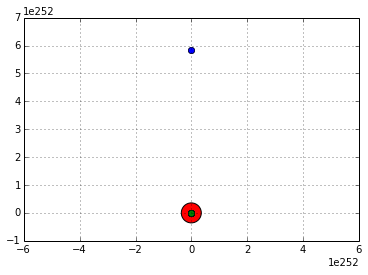

In [37]:
M = 10 ** 11                                                 #mass of central galaxy
t = [0, 10, .01]                                             #time over which galaxies will interact
dis_gal = [5, np.pi / 3, 0, - np.pi / 6, M]                  #initializes the disruting galaxy. Note dis_gal[3]. This is ω.
iterate(rings, dis_gal, t, M)                                #solves all the equations for that system
plt.show()                                                   #plots the result

Direct Passage Case:

In this case the disrupting galaxy has mass equal to that of the central galaxy ($M = S = 10^{11}$ solar masses) and it is rorating in the same direction as the central galaxy's stars ($\omega_1 = \omega_2$).

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 

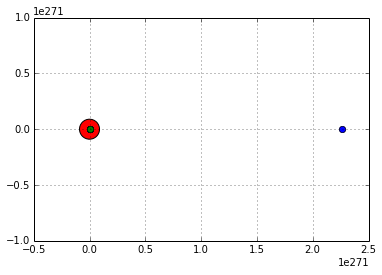

In [38]:
M = 10 ** 11                                                 #mass of central galaxy
t = [0, 10, .01]                                             #time over which galaxies will interact
dis_gal = [5, np.pi / 3, 0, np.pi / 6, M]                    #initializes the disruting galaxy. Again, note dis_gal[3]
iterate(rings, dis_gal, t, M)                                #solves all the equations for that system
plt.show()                                                   #plots the result

Passage of a Small Comapnion:

In this case the disrupting galaxy has one-fourth the mass of the central galaxy ($S = \frac1{4}M$) and it is rorating in the same direction as the central galaxy's stars ($\omega_1 = \omega_2$).

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 

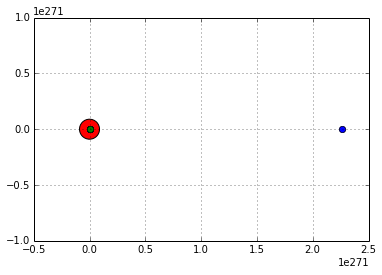

In [39]:
M = 10 ** 11                                                 #mass of central galaxy
t = [0, 10, .01]                                             #time over which galaxies will interact
dis_gal = [5, np.pi / 3, 0, np.pi / 6, M / 4]                #initializes the disruting galaxy. Again, note dis_gal[3]
iterate(rings, dis_gal, t, M)                                #solves all the equations for that system
plt.show()                                                   #plots the result

Passage of a Heavy Companion:
    
In this case the disrupting galaxy has four times the mass of the central galaxy ($S = 4M$) and it is rorating in the same direction as the central galaxy's stars ($\omega_1 = \omega_2$).

Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Excess work done on this call (perhaps wrong Dfun type).
Run with full_output = 1 to get quantitative information.
Repeated convergence failures (perhaps bad Jacobian or tolerances).
Run with ful

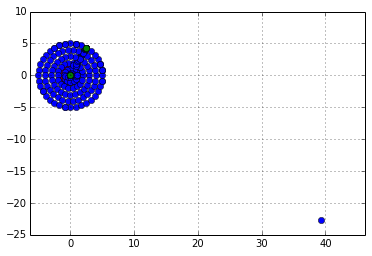

In [40]:
M = 10 ** 11                                                 #mass of central galaxy
t = [0, 10, .01]                                             #time over which galaxies will interact
dis_gal = [5, np.pi / 3, 0, np.pi / 6, 4 * M]                #initializes the disruting galaxy. Again, note dis_gal[3]
iterate(rings, dis_gal, t, M)                                #solves all the equations for that system
plt.show()  

In theory, animations of these evolutions could be made by recording each ring position at each time step and then linking them all together by some means, such as saving them together in a .gif format or using animation functions in matplotlib or another library.

# Errors:

As we can see, when I try to apply the odeint function to the stars in a galaxy, the results we get do not match what we expect. I suspect the problem arises in one of my conversions. I start out this notebook with a function that defines stars using polar coordinates, but the equations we were given are not compatible with them. I did not have the proper knowledge to convert them to polar, so I had to convert my position information back to cartesian as I looped through each star. This lead to a lot of extra mathematical bagage (for example, defining the x_loc, x_vel, etc. variables) and though I went over them multiple times I am faily certain I was simply unable to correctly account for that conversion.